In [1]:
import os
from dotenv import load_dotenv


load_dotenv()
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"] = "Customer Support"

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["ANTHROPIC_API_KEY"] = os.getenv("ANTHROPIC_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

In [2]:
import shutil
from database import populate_database

backup_file = "travel2.backup.sqlite"
db_file = "travel2.sqlite"
shutil.copy(backup_file, db_file)
populate_database()

example_time 2024-04-30 12:05:03.561731-04:00
current_time 2024-07-30 15:15:21.282396-04:00
time_diff 91 days 03:10:17.720665


### Tools


In [3]:
import tools

Initializing the my_package package
Split the document into 110 chunks.


### Graph


In [4]:
from typing import Annotated, TypedDict
from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [5]:
from datetime import datetime
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            configuration = config.get("configurable", {})
            passenger_id = configuration.get("passenger_id", None)
            state = {**state, "user_info": passenger_id}
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


llm = ChatOpenAI(model="gpt-4o-mini", temperature=1)
# llm = ChatAnthropic(model="claude-3-haiku-20240307", temperature=1)

primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support assistant for Swiss Airlines. "
            " Use the provided tools to search for flights, company policies, and other information to assist the user's queries. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            "\n\nCurrent user:\n\n{user_info}\n"
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())

part_1_tools = [
    TavilySearchResults(max_results=1),
    tools.fetch_user_flight_information,
    tools.search_flights,
    tools.lookup_policy,
    tools.update_ticket_to_new_flight,
    tools.cancel_ticket,
    tools.search_car_rentals,
    tools.book_car_rental,
    tools.update_car_rental,
    tools.cancel_car_rental,
    tools.search_hotels,
    tools.book_hotel,
    tools.update_hotel,
    tools.cancel_hotel,
    tools.search_trip_recommendations,
    tools.book_excursion,
    tools.update_excursion,
    tools.cancel_excursion,
]
part_1_assistant_runnable = primary_assistant_prompt | llm.bind_tools(part_1_tools)

Define graph


In [6]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph, START
from langgraph.prebuilt import tools_condition
from tools.utils import create_tool_node_with_fallback

builder = StateGraph(State)


# Define nodes: these do the work
builder.add_node("assistant", Assistant(part_1_assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(part_1_tools))
# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "assistant")

# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = SqliteSaver.from_conn_string(":memory:")
part_1_graph = builder.compile(checkpointer=memory)

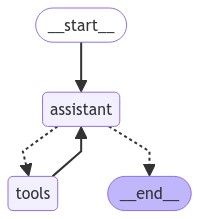

In [7]:
from IPython.display import Image, display

try:
    display(Image(part_1_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [8]:
import uuid
from tools.utils import _print_event

# Let's create an example conversation a user might have with the assistant
tutorial_questions = [
    "Hi there, what time is my flight?",
    "Am i allowed to update my flight to something sooner? I want to leave later today.",
    "Update my flight to sometime next week then",
    "The next available option is great",
    "what about lodging and transportation?",
    "Yeah i think i'd like an affordable hotel for my week-long stay (7 days). And I'll want to rent a car.",
    "OK could you place a reservation for your recommended hotel? It sounds nice.",
    "yes go ahead and book anything that's moderate expense and has availability.",
    "Now for a car, what are my options?",
    "Awesome let's just get the cheapest option. Go ahead and book for 7 days",
    "Cool so now what recommendations do you have on excursions?",
    "Are they available while I'm there?",
    "interesting - i like the museums, what options are there? ",
    "OK great pick one and book it for my second day there.",
    "Show me the booking details so far",
    "I need to book a return ticket.",
]


thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "3442 587242",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}


_printed = set()
# for question in tutorial_questions:
#     events = part_1_graph.stream(
#         input={"messages": ("user", question)},
#         config=config,
#         stream_mode="values",
#     )
#     for event in events:
#         _print_event(event, _printed)

# Problems

1. The assistant booked the flights, rented a car, and reserved a hotel room without confirmation from the user.
2. Recommendations can be improved.
3. The assistant had to do an explicit search just to get the user's relevant information. We can save a lot of time by fetching the user's relevant travel details immediately so the assistant can directly respond.

To solve the first two problems, we can use `interrupt_before` to pause the graph and return control to the user **before** executing any of the tools.


In [9]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    user_info: str


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support assistant for Swiss Airlines. "
            " Use the provided tools to search for flights, company policies, and other information to assist the user's queries. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            "\n\nCurrent user:\n\n{user_info}\n"
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())

part_2_tools = [
    TavilySearchResults(max_results=1),
    tools.fetch_user_flight_information,
    tools.search_flights,
    tools.lookup_policy,
    tools.update_ticket_to_new_flight,
    tools.cancel_ticket,
    tools.search_car_rentals,
    tools.book_car_rental,
    tools.update_car_rental,
    tools.cancel_car_rental,
    tools.search_hotels,
    tools.book_hotel,
    tools.update_hotel,
    tools.cancel_hotel,
    tools.search_trip_recommendations,
    tools.book_excursion,
    tools.update_excursion,
    tools.cancel_excursion,
]
part_2_assistant_runnable = assistant_prompt | llm.bind_tools(part_2_tools)

Define graph


In [10]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)


def user_info(state: State):
    return {"user_info": tools.fetch_user_flight_information.invoke({})}


# NEW: The fetch_user_info node runs first, meaning our assistant can see the user's flight information without
# having to take an action
builder.add_node("fetch_user_info", user_info)
builder.add_edge(START, "fetch_user_info")
builder.add_node("assistant", Assistant(part_2_assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(part_2_tools))
builder.add_edge("fetch_user_info", "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = SqliteSaver.from_conn_string(":memory:")
part_2_graph = builder.compile(
    checkpointer=memory,
    # NEW: The graph will always halt before executing the "tools" node.
    # The user can approve or reject (or even alter the request) before
    # the assistant continues
    interrupt_before=["tools"],
)

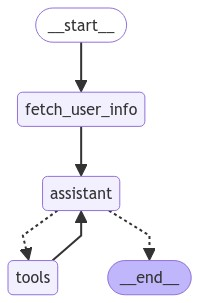

In [11]:
from IPython.display import Image, display

try:
    display(Image(part_2_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [12]:
import uuid
from langchain_core.messages import ToolMessage

thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "3442 587242",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}


_printed = set()
# We can reuse the tutorial questions from part 1 to see how it does.
for question in tutorial_questions:
    events = part_2_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)
    snapshot = part_2_graph.get_state(config)
    while snapshot.next:
        # We have an interrupt! The agent is trying to use a tool, and the user can approve or deny it
        # Note: This code is all outside of your graph. Typically, you would stream the output to a UI.
        # Then, you would have the frontend trigger a new run via an API call when the user has provided input.
        user_input = input(
            "Do you approve of the above actions? Type 'y' to continue;"
            " otherwise, explain your requested changed.\n\n"
        )
        if user_input.strip().lower() == "y":
            # Just continue
            result = part_2_graph.invoke(None, config)
        else:
            # Satisfy the tool invocation by
            # providing instructions on the requested changes / change of mind
            result = part_2_graph.invoke(
                {
                    "messages": [
                        ToolMessage(
                            tool_call_id=event["messages"][-1].tool_calls[0]["id"],
                            content=f"API call denied by user. Reasoning: '{user_input}'. Continue assisting, accounting for the user's input.",
                        )
                    ]
                },
                config,
            )
        snapshot = part_2_graph.get_state(config)

================================ Human Message =================================

Hi there, what time is my flight?
Results: [{'ticket_no': '7240005432906569', 'book_ref': 'C46E9F', 'flight_id': 19250, 'flight_no': 'LX0112', 'departure_airport': 'CDG', 'arrival_airport': 'BSL', 'scheduled_departure': '2024-07-30 15:19:21.282396-04:00', 'scheduled_arrival': '2024-07-30 16:49:21.282396-04:00', 'seat_no': '18E', 'fare_conditions': 'Economy'}]
================================== Ai Message ==================================

Your flight LX0112 is scheduled to depart from Charles de Gaulle Airport (CDG) at 15:19 (local time) and is expected to arrive at EuroAirport Basel-Mulhouse-Freiburg (BSL) at 16:49 (local time). 

Please note that your scheduled departure time is just a few minutes away, as the current time is 15:15.
================================ Human Message =================================

Am i allowed to update my flight to something sooner? I want to leave later today.
Results

BadRequestError: Error code: 400 - {'error': {'message': "An assistant message with 'tool_calls' must be followed by tool messages responding to each 'tool_call_id'. The following tool_call_ids did not have response messages: call_VImDPHd01iIeSgoscFxXsRMn", 'type': 'invalid_request_error', 'param': 'messages', 'code': None}}